# quantify degree of geostrophy with instantaneous fields

Xiaolong initial [notebook](https://github.com/xy6g13/equinox_working/blob/master/sandbox/Reconstruction/Geostrophy%20metric.ipynb)

In [1]:
import os, sys, shutil
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set(style="ticks", color_codes=True)

import xgcm

from mitequinox.utils import *
from mitequinox.dynamic import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1)
#w = cluster.scale(40)
w = cluster.scale(5) # postprocessing

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.37.25:33559 Dashboard: http://10.135.37.25:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
# load data


In [5]:
ds_var = xr.open_zarr(work_data_dir+'spectra/%s_variance_per_band.zarr'%('SSUV'))

In [6]:
print(ds_var.band)

<xarray.DataArray 'band' (band: 5)>
array(['semidiurnal', 'diurnal', 'inertial', 'subdiurnal', 'high'],
      dtype=object)
Coordinates:
  * band     (band) object 'semidiurnal' 'diurnal' ... 'subdiurnal' 'high'


In [15]:
dsu = xr.concat([xr.open_zarr(work_data_dir+'mbal/%sgeo_f%02d_rms.zarr'%('u',face)) 
               for face in range(13)],dim='face').rename({'diff':'udiff'})
dsv = xr.concat([xr.open_zarr(work_data_dir+'mbal/%sgeo_f%02d_rms.zarr'%('v',face)) 
               for face in range(13)],dim='face').rename({'diff':'vdiff'})
ds = xr.merge([dsu,dsv, ds_var])
ds = ds.assign_coords(f=2*omega_earth*np.sin(np.deg2rad(ds.YC))) # at center points
ds = ds.isel(i=slice(0,None,8),j=slice(0,None,8)).persist()
ds['u_rms'] = ds.vgeo_coriolis_linear/np.abs(ds.f)
ds['v_rms'] = ds.ugeo_coriolis_linear/np.abs(ds.f)
ds['u_ageo_rms'] = ds.vdiff/np.abs(ds.f)
ds['v_ageo_rms'] = ds.udiff/np.abs(ds.f)
print(ds)

<xarray.Dataset>
Dimensions:               (band: 5, face: 13, i: 540, j: 540)
Coordinates:
  * i                     (i) int64 0 8 16 24 32 40 ... 4280 4288 4296 4304 4312
  * j                     (j) int64 0 8 16 24 32 40 ... 4280 4288 4296 4304 4312
    CS                    (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
    Depth                 (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
    SN                    (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
    XC                    (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
    YC                    (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
  * face                  (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * band                  (band) object 'semidiurnal' 'diurnal' ... 'high'
    mask                  (face, j, i) float64 dask.array<shape=(13, 540, 540)

In [16]:
# mask some points
ds = ds.where(ds.Depth>500.).where(np.abs(ds.YC)<60.).where(np.abs(ds.YC)>5.)

### zonal momentum balance - meridional flow

In [ ]:
plot_pretty(ds.vrms, title='meridional current rms [m/s]',
            vmin=0., vmax=.5, cmap=cm.thermal, ignore_face=[6],
            colorbar=True, colorbar_kwargs={'shrink':.5})

In [ ]:
toplt = ds.udiff/np.abs(ds.f)
toplt = toplt.where(toplt<1.)
plot_pretty(toplt, title='ageostrophic meridional current rms [m/s]',
            vmin=0., vmax=1., cmap=cm.deep_r, ignore_face=[6],
            colorbar=True, colorbar_kwargs={'shrink':.5})

In [9]:
def jointplot(X, Y, xbins, ybins, face=range(13), log=False):
    x = X.values.flatten()
    y = Y.values.flatten()
    if log:
        x = np.log10(x)
        y = np.log10(y)
        lxbins=np.arange(*xbins)
        lybins=np.arange(*ybins)        
    else:
        lxbins=np.arange(0.,*xbins)
        lybins=np.arange(0.,*ybins)
    g = sns.JointGrid(x, y, xlim=(lxbins[0],lxbins[-1]),ylim=(lybins[0],lybins[-1]))
    #
    sns.kdeplot(x, color='.5', clip=(lxbins[0],lxbins[-1]), ax=g.ax_marg_x, vertical=False)
    sns.kdeplot(y, color='.5', clip=(lybins[0],lybins[-1]), ax=g.ax_marg_y, vertical=True)
    #
    g = g.plot_joint(plt.hexbin, cmap=cm.deep, extent=[lxbins[0], lxbins[-1], lybins[0], lybins[-1]])
    #g = g.plot_joint(sns.regplot)
    #
    #if log:
    #    g.set_axis_labels(bandx+' log10 [cm²/s²]', bandy+' log10 [cm²/s²]')
    #else:
    #    g.set_axis_labels(bandx+' [cm²/s²]', bandy+' [cm²/s²]')
    return g

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


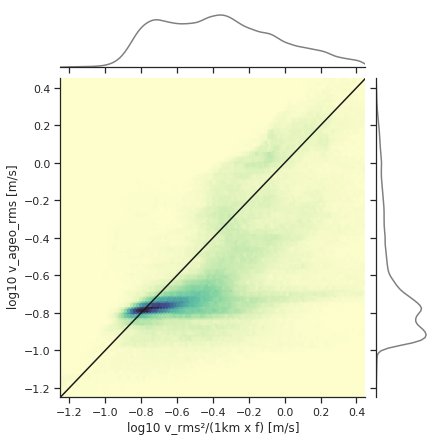

In [34]:
#g = jointplot(ds.vrms*1e2 , (ds.udiff/np.abs(ds.f))*1e2,(0.5, 2.,.1),(0.5,3.,.1), log=True)
g = jointplot(ds.v_rms**2/1e3/ds.f , ds.v_ageo_rms,(-1.25, .5,.1),(-1.25,.5,.1), log=True)
xref = np.array([-2.5,.5])
g.ax_joint.plot(xref,xref,'k')
#g.ax_joint.plot(xref,2*xref,'k')
g.set_axis_labels('log10 v_rms²/(1km x f) [m/s]', ' log10 v_ageo_rms [m/s]')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


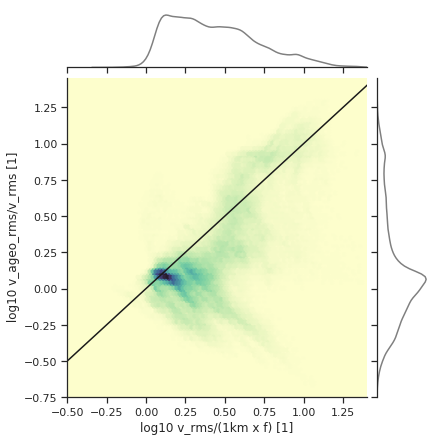

In [39]:
#g = jointplot(ds.vrms*1e2 , (ds.udiff/np.abs(ds.f))*1e2,(0.5, 2.,.1),(0.5,3.,.1), log=True)
g = jointplot(ds.v_rms/1e3/ds.f , ds.v_ageo_rms/ds.v_rms,(-.5, 1.5,.1),(-.75,1.5,.1), log=True)
xref = np.array([-.5,1.5])
g.ax_joint.plot(xref,xref,'k')
#g.ax_joint.plot(xref,2*xref,'k')
g.set_axis_labels('log10 v_rms/(1km x f) [1]', ' log10 v_ageo_rms/v_rms [1]')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


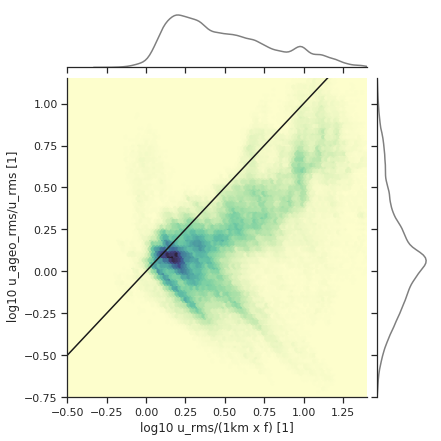

In [51]:
g = jointplot(ds.u_rms/1e3/ds.f , ds.u_ageo_rms/ds.u_rms,(-.5, 1.5,.1),(-.75,1.25,.1), log=True)
xref = np.array([-.5,1.5])
g.ax_joint.plot(xref,xref,'k')
#g.ax_joint.plot(xref,2*xref,'k')
g.set_axis_labels('log10 u_rms/(1km x f) [1]', ' log10 u_ageo_rms/u_rms [1]')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


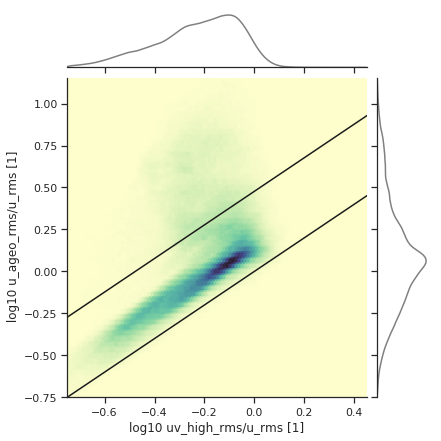

In [58]:
#g = jointplot(ds.u_rms/1e3/ds.f , ds.u_ageo_rms/ds.v_rms,(-.5, 1.5,.1),(-.75,1.5,.1), log=True)
g = jointplot(np.sqrt(ds.uv_variance.sel(band='high'))/ds.u_rms , ds.u_ageo_rms/ds.u_rms,
              (-.75, .5,.1),(-.75,1.25,.1), log=True)
xref = np.array([-2.,.5])
g.ax_joint.plot(xref,xref,'k')
g.ax_joint.plot(xref,xref+np.log10(3),'k')
#g.ax_joint.plot(xref,2*xref,'k')
g.set_axis_labels('log10 uv_high_rms/u_rms [1]', ' log10 u_ageo_rms/u_rms [1]')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


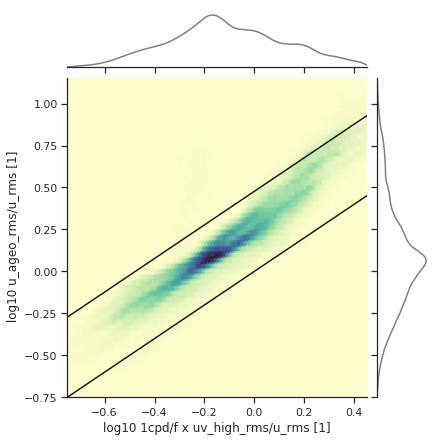

In [57]:
#g = jointplot(ds.u_rms/1e3/ds.f , ds.u_ageo_rms/ds.v_rms,(-.5, 1.5,.1),(-.75,1.5,.1), log=True)
g = jointplot(2.*np.pi/86400./ds.f*np.sqrt(ds.uv_variance.sel(band='high'))/ds.u_rms , ds.u_ageo_rms/ds.u_rms,
              (-.75, .5,.1),(-.75,1.25,.1), log=True)
xref = np.array([-2.,.5])
g.ax_joint.plot(xref,xref,'k')
g.ax_joint.plot(xref,xref+np.log10(3),'k')
#g.ax_joint.plot(xref,2*xref,'k')
g.set_axis_labels('log10 1cpd/f x uv_high_rms/u_rms [1]', ' log10 u_ageo_rms/u_rms [1]')

---

### zonally average kinetic energy

In [ ]:
KE = np.sqrt((ds.ugeo_coriolis_linear**2+ds.vgeo_coriolis_linear**2))/np.abs(ds.f)
dlat = 1.
lat_edges = np.arange(-60.-dlat/2.,60.+dlat,dlat)
lat = lat_edges[:-1]+dlat/2.
KE_av = KE.groupby_bins('YC',lat_edges).mean()

In [ ]:
KE_av.plot()

---

In [ ]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [59]:
cluster.close()